# A simple sentiment prototype

In [1]:
import os  # manipulate paths
import pandas as pd  # SQL-like operations and convenience functions
import joblib  # save and load models

Download the Sentiment140 data from [their website](http://help.sentiment140.com/for-students) and set `DATA_DIR` to the directory in which you have put the `CSV` files.

In [2]:
DATA_DIR = "/home/sean/git/data-studio/election sentiment/"
training_csv_file = os.path.join(DATA_DIR, 'training.1600000.processed.noemoticon.csv')

## A peek at the data

In [3]:
names = ('polarity', 'id', 'date', 'query', 'author', 'text')
df = pd.read_csv(training_csv_file, encoding='latin1', names=names)

In [4]:
pd.options.display.max_colwidth = 140  # allow wide columns
df.head()  # show first 5 rows

,polarity,id,date,query,author,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [5]:
df.tail()

,polarity,id,date,query,author,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H


In [6]:
df['polarity'].replace({0: -1, 4: 1}, inplace=True)
text = df['text']
target = df['polarity'].values

In [7]:
print(len(target), len(text))

1600000 1600000


## Train the model

Set 20% of the data aside to test the trained model

In [8]:
from sklearn.cross_validation import train_test_split

text_train, text_validation, target_train, target_validation = (
    train_test_split(text, target, test_size=0.2, random_state=42)
)

Build a pipeline

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=100000)
feature_selector = SelectKBest(chi2, k=5000)
classifier = LogisticRegressionCV(n_jobs=4)

This next cell took ~3 minutes to run on my machine

In [10]:
if os.path.exists('model.pkl'):
    sentiment_pipeline = joblib.load('model.pkl')
else:
    sentiment_pipeline = Pipeline((
        ('v', vectorizer),
        ('f', feature_selector),
        ('c', classifier)
    ))
    sentiment_pipeline.fit(text_train, target_train)
    joblib.dump(sentiment_pipeline, 'model.pkl');

## Test the model

In [11]:
print(sentiment_pipeline.predict(['bad', 'good', "didnt like", "today was a good day", "i hate this product"]))

[-1  1 -1  1 -1]


In [12]:
for text, target in zip(text_validation[:10], target_validation[:10]):
    print(sentiment_pipeline.predict([text])[0], target, '\t', text)

1 -1 	 @chrishasboobs AHHH I HOPE YOUR OK!!! 
1 -1 	 @misstoriblack cool , i have no tweet apps  for my razr 2
1 -1 	 @TiannaChaos i know  just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u
-1 -1 	 School email won't open  and I have geography stuff on there to revise! *Stupid School* :'(
1 -1 	 upper airways problem 
-1 -1 	 Going to miss Pastor's sermon on Faith... 
1 1 	 on lunch....dj should come eat with me 
-1 -1 	 @piginthepoke oh why are you feeling like that? 
-1 -1 	 gahh noo!peyton needs to live!this is horrible 
1 1 	 @mrstessyman thank you glad you like it! There is a product review bit on the site  Enjoy knitting it!


In [13]:
sentiment_pipeline.score(text_validation, target_validation)

0.79934375000000002

## What did the model learn?

In [14]:
feature_names = sentiment_pipeline.steps[0][1].get_feature_names()
feature_names = [feature_names[i] for i in 
                 sentiment_pipeline.steps[1][1].get_support(indices=True)]

def show_most_informative_features(feature_names, clf, n=1000):
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [15]:
show_most_informative_features(feature_names, sentiment_pipeline.steps[2][1], n=500)

	-4.3140	clean me       		3.2612	no worries     
	-4.1418	inaperfectworld		3.1769	sad sad        
	-3.6485	not happy      		2.7926	no problem     
	-3.6359	sadd           		2.7699	fuzzball       
	-3.5808	dontyouhate    		2.7384	cannot wait    
	-3.5536	passed away    		2.5609	no prob        
	-3.4684	pakcricket     		2.4936	nothing wrong  
	-3.2728	boohoo         		2.3752	smiling        
	-3.1417	heartbreaking  		2.3516	cant wait      
	-3.1155	heartbroken    		2.2982	gracias        
	-3.0913	devastated     		2.1431	not bad        
	-3.0337	not looking    		2.0283	no probs       
	-2.9638	sad            		2.0117	my pleasure    
	-2.9215	neda           		1.9713	congratulations
	-2.8961	saddened       		1.8829	musicmonday    
	-2.8512	noooooooooo    		1.8358	crack me       
	-2.8494	ftl            		1.7987	heheh          
	-2.8401	sadface        		1.7907	welcome        
	-2.8396	never reply    		1.7893	goodsex        
	-2.8307	not nice       		1.7889	just sayin     
	-2.8272	taking fore

## all of the above is copied verbatim from Mike Williams at https://github.com/williamsmj/sentiment. all credit to him and his collaborators for building this model. next, I will be feeding the speeches from trump and clinton at their respective conventions to the model one sentence at a time.

In [16]:
import codecs
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.util import ngrams
import re

In [17]:
with codecs.open('clinton.txt', "r",encoding='utf-8', errors='ignore') as fdata:
    clinton=fdata.read().replace('\r\n', '').replace('&quot;', '"').replace('<p>', '').replace('</p>', ' ')

FileNotFoundError: [Errno 2] No such file or directory: 'clinton.txt'

In [142]:
clinton_grams=ngrams(clinton.split(), 10)
flat_clinton_grams=[]
for gram in clinton_grams:
    flat_clinton_grams.append(' '.join(gram))

In [150]:
re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', clinton)

['Thank you! Thank you for that amazing welcome.',
 'And Chelsea, thank you.',
 " I'm so proud to be your mother and so proud of the woman you've become.",
 ' Thanks for bringing Marc into our family, and Charlotte and Aidan into the world.',
 'And Bill, that conversation we started in the law library 45 years ago is still going strong.',
 "It's lasted through good times that filled us with joy, and hard times that tested us.",
 "  And I've even gotten a few words in along the way.",
 ' On Tuesday night, I was so happy to see that my Explainer-in-Chief is still on the job.',
 "I'm also grateful to the rest of my family and the friends of a lifetime.",
 ' To all of you whose hard work brought us here tonight And to those of you who joined our campaign this week.',
 "And what a remarkable week it's been.",
 'We heard the man from Hope, Bill Clinton.',
 'And the man of Hope, Barack Obama.',
 " America is stronger because of President Obama's leadership, and I'm better because of his frien

In [151]:
sent_total=0
sent_track=[]
for count, sentence in enumerate(re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', clinton)):
    sent=sentiment_pipeline.predict([sentence])
    sent_total+=sent[0]
    sent_track.append(sent_total)
    #print(sent_total)#count, sent, sentence)
clinton_df=pd.DataFrame(sent_track, columns=['total_sentiment'])

In [74]:
pd.DataFrame?

In [88]:
clinton_df=pd.DataFrame(sent_track, columns=['total_sentiment'])

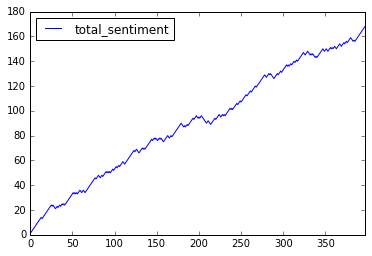

In [152]:
clinton_df.plot()

In [145]:
with codecs.open('trump.txt', "r",encoding='utf-8', errors='ignore') as fdata:
    trump=fdata.read().replace('\r\n', '').replace('&quot;', '"').replace('<p>', '').replace('</p>', ' ')

In [146]:
trump_grams=ngrams(trump.split(), 10)
flat_trump_grams=[]
for gram in trump_grams:
    flat_trump_grams.append(' '.join(gram))

In [155]:
sent_total=0
sent_track=[]
for count, sentence in enumerate(re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', trump)):
    sent=sentiment_pipeline.predict([sentence])
    sent_total+=sent[0]
    sent_track.append(sent_total)
    print(sent, sentence)
trump_df=pd.DataFrame(sent_track, columns=['total_sentiment'])

[1] Friends, delegates and fellow Americans: I humbly and gratefully accept your nomination for the presidency of the United States.
[1] Together, we will lead our party back to the White House, and we will lead our country back to safety, prosperity, and peace.
[1] We will be a country of generosity and warmth.
[1] But we will also be a country of law and order.
[1] Our Convention occurs at a moment of crisis for our nation.
[1] The attacks on our police, and the terrorism in our cities, threaten our very way of life.
[-1] Any politician who does not grasp this danger is not fit to lead our country.
[1]  Americans watching this address tonight have seen the recent images of violence in our streets and the chaos in our communities.
[-1] Many have witnessed this violence personally, some have even been its victims.
[-1] I have a message for all of you: the crime and violence that today afflicts our nation will soon come to an end.
[1] Beginning on January 20th 2017, safety will be resto

In [157]:
with codecs.open('obama-2012.txt', "r",encoding='utf-8', errors='ignore') as fdata:
    obama12=fdata.read()#.replace('\r\n', '').replace('&quot;', '"').replace('<p>', '').replace('</p>', ' ')

In [159]:
sent_total=0
sent_track=[]
for count, sentence in enumerate(re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', obama12)):
    sent=sentiment_pipeline.predict([sentence])
    sent_total+=sent[0]
    sent_track.append(sent_total)
obama12_df=pd.DataFrame(sent_track, columns=['total_sentiment'])

In [166]:
with codecs.open('romney.txt', "r",encoding='utf-8', errors='ignore') as fdata:
    romney=fdata.read().replace('\r\n', '').replace('&quot;', '"').replace('<p>', '').replace('</p>', ' ')

In [167]:
sent_total=0
sent_track=[]
for count, sentence in enumerate(re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', romney)):
    sent=sentiment_pipeline.predict([sentence])
    sent_total+=sent[0]
    sent_track.append(sent_total)
romney_df=pd.DataFrame(sent_track, columns=['total_sentiment'])

In [189]:
df.plot?

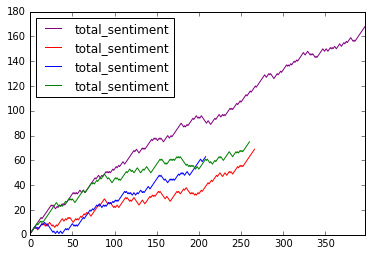

In [168]:
fig, ax = plt.subplots()
clinton_df.plot(color='purple', ax=ax)
trump_df.plot(color='red', ax=ax)
obama12_df.plot(color='blue', ax=ax)
romney_df.plot(color='green', ax=ax)

In [18]:
def speech_analyzer(name):
    with codecs.open('speeches/'+name+'.txt', "r",encoding='utf-8', errors='ignore') as fdata:
        doc=fdata.read().replace('\r\n', '').replace('&quot;', '"').replace('<div>', '').replace('</div>', '').replace('<p>', '').replace('</p>', ' ')
    sent_total=0
    sent_track=[]
    for count, sentence in enumerate(re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', doc)):
        sent=sentiment_pipeline.predict([sentence])
        sent_total+=sent[0]
        sent_track.append(sent_total)
    return pd.DataFrame(sent_track, columns=['total_sentiment'])

In [19]:
string='words words words stuff and junk'
len(string.split())

6

In [20]:
def speech_analyzer2(name):
    with codecs.open('speeches/'+name+'.txt', "r",encoding='utf-8', errors='ignore') as fdata:
        doc=fdata.read().replace('\r\n', '').replace('&quot;', '"').replace('<div>', '').replace('</div>', '').replace('<p>', '').replace('</p>', ' ')
    sent_total=0
    sent_track=[]
    for count, sentence in enumerate(re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', doc)):
        sent=sentiment_pipeline.predict([sentence])
        sent_total+=sent[0]*sum([len(x) for x in sentence.split()])/len(sentence.split())
        sent_track.append(sent_total)
    return pd.DataFrame(sent_track, columns=['total_sentiment'])

In [31]:
speech_list=['Clinton', 'Trump', 'Obama-2012', 'Romney', 'Obama-2008', 'McCain', 'Kerry', 'Bush-2004', 'Gore', 'Bush-2000', 'Clinton-1996', 'Dole', 'Clinton-1992', 'Bush-1992', 'Bush-1988', 'Dukakis', 'Mondale', 'Reagan-1984', 'Reagan-1980', 'Carter-1980']
for speech in speech_list:
    print(speech.lower())

clinton
trump
obama-2012
romney
obama-2008
mccain
kerry
bush-2004
gore
bush-2000
clinton-1996
dole
clinton-1992
bush-1992
bush-1988
dukakis
mondale
reagan-1984
reagan-1980
carter-1980


In [214]:
plt.savefig?

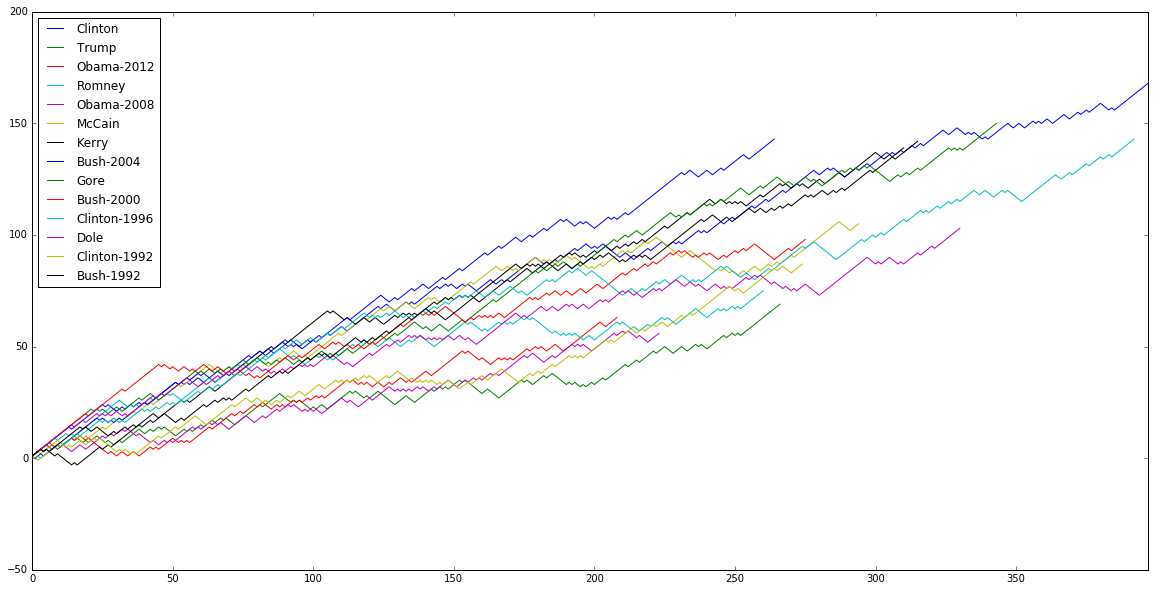

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
for speech in speech_list:
    speech_analyzer(speech.lower()).plot(ax=ax)
plt.legend(speech_list, loc=0)
plt.savefig('acceptance_speeches.pdf')
plt.show()

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


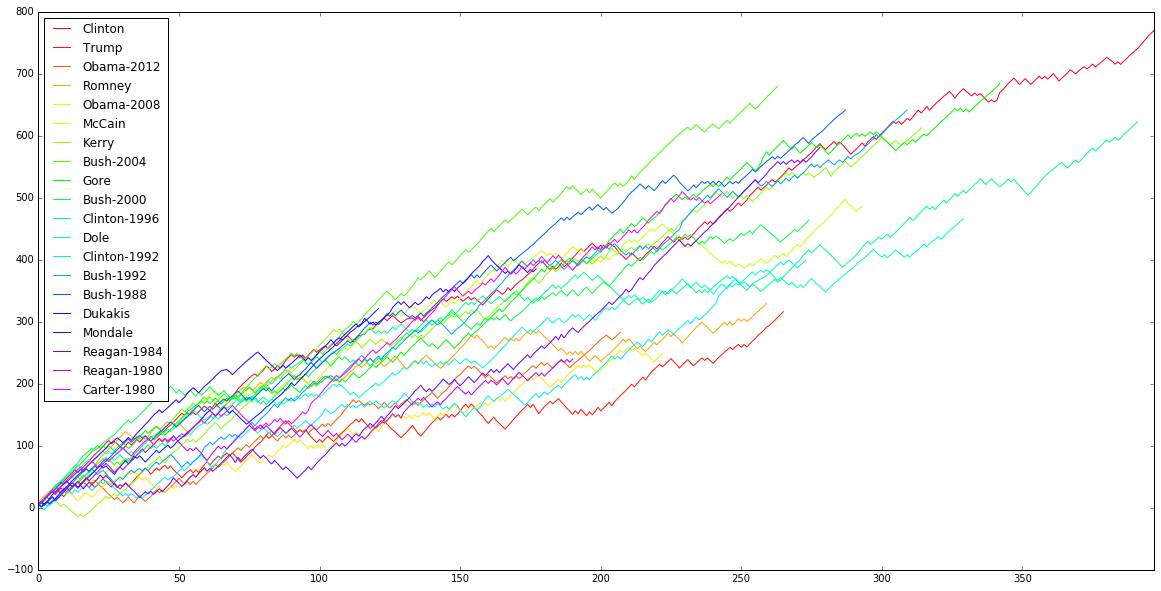

In [33]:
fig, ax = plt.subplots(figsize=(20, 10))
cm = plt.get_cmap('gist_rainbow')
ax.set_color_cycle([cm(1.*i/20) for i in range(20)])
for speech in speech_list:
    speech_analyzer2(speech.lower()).plot(ax=ax)
plt.legend( speech_list, loc=0 )
plt.savefig('acceptance_speeches_v4.pdf')
plt.show()

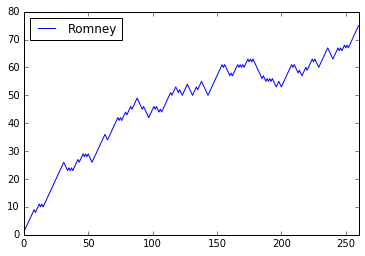

In [201]:
#fig, ax = plt.subplots()
speech_analyzer('romney').plot()
plt.legend( ('Romney',), loc=0 )
plt.show()

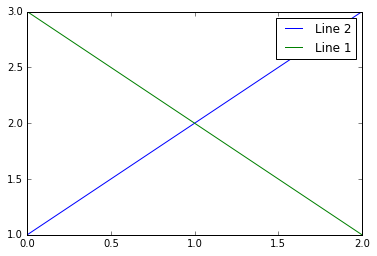

In [195]:
line_up, = plt.plot([1,2,3], label='Line 2')
line_down, = plt.plot([3,2,1], label='Line 1')
plt.legend(handles=[line_up, line_down])